In [79]:
import pandas as pd
import requests
import yaml
import sqlalchemy
from sqlalchemy.orm import declarative_base, sessionmaker, relationship, backref
from sqlalchemy import (
    ForeignKey,
    create_engine,
    Column,
    Integer,
    Float,
    String,
    DateTime,
    Boolean, 
    Table,
)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from eralchemy2 import render_er
import re

In [92]:
REFRESH_TOKEN_URL = "https://api.ah.nl/mobile-auth/v1/auth/token/refresh"
TOKEN_URL = "https://api.ah.nl/mobile-auth/v1/auth/token"
RECEIPTS_URL = "https://api.ah.nl/mobile-services/v1/receipts/"
RECEIPT_DETAILS_URL = "https://api.ah.nl/mobile-services/v2/receipts/{transaction_id}"

In [99]:
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)

In [97]:
def login():
    """Login to the API."""
    data = {
        "code": config["api"]["code"],
        "clientId": "appie",
    }
    response = requests.post(TOKEN_URL, json=data, headers={"Content-Type": "application/json"})
    response.raise_for_status()
    tokens = response.json()
    config["api"]["access_token"] = tokens["access_token"]
    config["api"]["refresh_token"] = tokens["refresh_token"]
    with open("config.yml", "w") as f:
        yaml.dump(config, f)


def update_tokens():
    """Update the access token and refresh token in the config file."""
    tokens = fetch_new_tokens()
    config["api"]["access_token"] = tokens["access_token"]
    config["api"]["refresh_token"] = tokens["refresh_token"]
    with open("config.yml", "w") as f:
        yaml.dump(config, f)

def fetch_new_tokens():
    """Fetch new tokens using the refresh token."""
    data = {
        "refreshToken": config["api"]["refresh_token"],
        "clientId": "appie",
    }
    response = requests.post(REFRESH_TOKEN_URL, json=data, headers={"Content-Type": "application/json"})
    response.raise_for_status()
    return response.json()


def fetch_receipts():
    """Fetch the receipts from the API."""
    response = requests.get(RECEIPTS_URL, headers={"Authorization": f"Bearer {config['api']['access_token']}"})
    if response.status_code == 401:
        update_tokens()
        response = requests.get(RECEIPTS_URL, headers={"Authorization": f"Bearer {config['api']['access_token']}"})
    response.raise_for_status()
    return response.json()


def fetch_receipt_details(transaction_id):
    """Fetch the details of a receipt from the API."""
    url = RECEIPT_DETAILS_URL.format(transaction_id=transaction_id)
    response = requests.get(url, headers={"Authorization": f"Bearer {config['api']['access_token']}"})
    if response.status_code == 401:
        update_tokens()
        response = requests.get(url, headers={"Authorization": f"Bearer {config['api']['access_token']}"})
    response.raise_for_status()
    return response.json()


class Product:
    def __init__(self, quantity: float=None, unit: str=None, description: str=None, price: float=None, amount: float=None, indicator: str=None):
        self.quantity = quantity
        self.unit = unit
        self.description = description
        self.price = price
        self.amount = amount
        self.indicator = indicator

    def __repr__(self):
        return f"Product(quantity={self.quantity}, unit={self.unit}, description={self.description}, price={self.price}, amount={self.amount}, indicator={self.indicator})"



In [100]:

login()

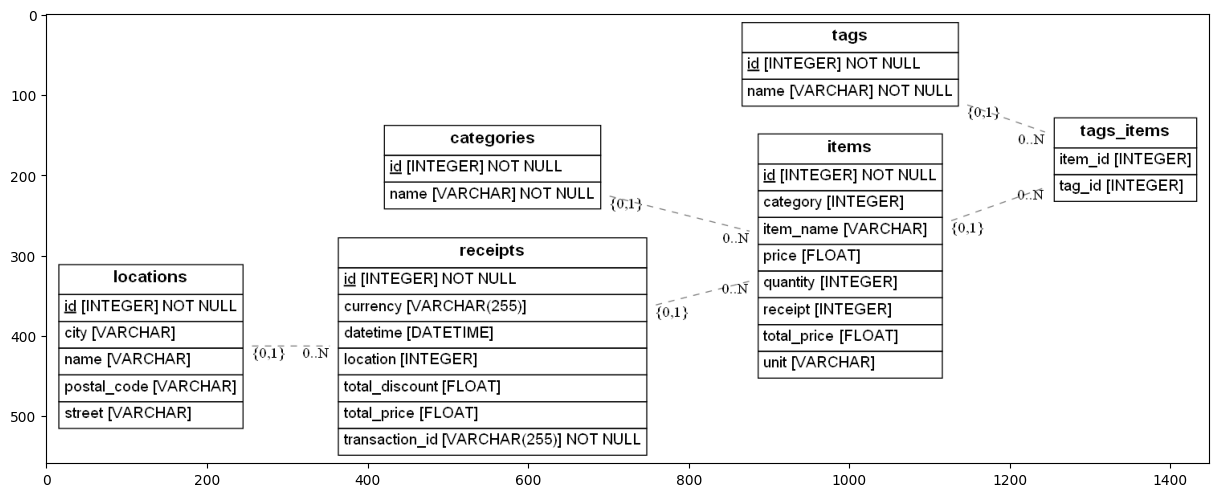

In [66]:
# Create database connection based on config. Either use a local SQLite database, remote MySQL database or a PostgreSQL database.
if config["database"]["type"] == "sqlite":
    engine = create_engine("sqlite:///" + config["database"]["path"])
elif config["database"]["type"] == "mysql":
    engine = create_engine(
        f"mysql+pymysql://{config['database']['username']}:{config['database']['password']}@{config['database']['host']}/{config['database']['database']}"
    )
elif config["database"]["type"] == "postgresql" or config["database"]["type"] == "postgres":
    engine = create_engine(
        f"postgresql://{config['database']['username']}:{config['database']['password']}@{config['database']['host']}/{config['database']['database']}"
    )
else:
    raise ValueError("Database type not supported.")

Base = declarative_base()


class DbReceipt(Base):
    __tablename__ = "receipts" 

    id = Column(Integer, primary_key=True)
    transaction_id = Column(String(255), nullable=False)
    datetime = Column(DateTime)
    location = Column(Integer, ForeignKey("locations.id"))
    total_price = Column(Float)
    total_discount = Column(Float)
    currency = Column(String(255))


class DbItem(Base):
    __tablename__ = "items"
    id = Column(Integer, primary_key=True)
    item_name = Column(String)
    receipt = Column(Integer, ForeignKey("receipts.id"))
    quantity = Column(Integer)
    unit = Column(String)
    price = Column(Float)
    total_price = Column(Float)
    category = Column(Integer, ForeignKey("categories.id"))
    


class DbCategory(Base):
    __tablename__ = "categories"
    id = Column(Integer, primary_key=True)
    name = Column(String, nullable=False)


class DbLocation(Base):
    __tablename__ = "locations"
    id = Column(Integer, primary_key=True)
    name = Column(String)
    street = Column(String)
    city = Column(String)
    postal_code = Column(String)


class DbTag(Base):
    __tablename__ = "tags"
    id = Column(Integer, primary_key=True)
    name = Column(String, nullable=False)


# Many-to-many tags and items
tags_items = Table(
    "tags_items",
    Base.metadata,
    Column("tag_id", Integer, ForeignKey("tags.id")),
    Column("item_id", Integer, ForeignKey("items.id")),
)

Base.metadata.create_all(engine)

filename = 'mymodel.png'
render_er(Base.metadata, filename)
imgplot = plt.imshow(mpimg.imread(filename))
plt.show()


In [101]:
def parse_products(items: list) -> list:
    products = []
    for row in items:
        quantity, unit = parse_quantity(row["quantity"])
        price = row["price"] if "price" in row else None
        product = Product(quantity, unit, row["description"], price, row["amount"], row["indicator"])
        products.append(product)
    return products


def parse_quantity(quantity: str) -> tuple[float, str]:
    quantity = quantity.replace(",", ".")
    regex_result = re.match(r'(\d+.\d+)([a-zA-Z]+)', quantity)
    if quantity.isnumeric():
        return float(quantity), None
    elif regex_result:
        return float(regex_result.group(1)), regex_result.group(2)


def get_products(receipt: dict) -> list:
    products = []
    for item in receipt["items"]:
        products.append(item["description"])
    return products
        

In [102]:
receipts = fetch_receipts()
receipts[0]

{'transactionId': 'AH35d19d2495e30f57ed03c6f0544b7da2071af',
 'transactionMoment': '2022-11-07T15:01:00Z',
 'total': {'amount': {'amount': 4.34, 'currency': 'EUR'}},
 'totalDiscount': {'amount': 0},
 'storeAddress': {'street': 'Potterstraat [Neude]',
  'houseNumber': '1',
  'postalCode': '3512TA',
  'city': 'Utrecht',
  'countryCode': 'NLD'}}

In [103]:
receipt_details = fetch_receipt_details(receipts[1]["transactionId"])
# remove all elements in details that come before {"type": 'products-header'}
# remove all elements in details that come after {"type": 'total', "label": 'Totaal'}

receipt_rows = receipt_details["receiptUiItems"]


# Remove all elements before "bonuskaart" (and that element itself) and after "subtotaal" to get only the products that have been purchased (without discounts etc.)
before_index = next((index for (index, d) in enumerate(receipt_rows) if d["type"].lower() == "product" and d["description"].lower() == "bonuskaart"), None)
after_index = next((index for (index, d) in enumerate(receipt_rows) if d["type"].lower() == "subtotal" and d["text"].lower() == "subtotaal"), None)
product_rows = receipt_rows[before_index + 1:after_index]

# remove all entires don't have the type "product"
product_rows = [item for item in product_rows if item["type"].lower() == "product"]
# # get first and last occurence of {"type": 'product'}
# first_index = next((index for (index, d) in enumerate(product_rows) if d["type"].lower() == "product"), None)
# last_index = next((index for (index, d) in enumerate(reversed(product_rows)) if d["type"].lower() == "product"), None)
# # get all items between first and last occurence of {"type": 'product'}
# if last_index is not None:
#     last_index = len(product_rows) - last_index
# product_rows = product_rows[first_index:last_index]
product_rows
parse_products(product_rows)

[Product(quantity=1.0, unit=None, description=AH CREME FR, price=None, amount=1,49, indicator=),
 Product(quantity=1.0, unit=None, description=HALFV MELK, price=None, amount=1,69, indicator=),
 Product(quantity=0.108, unit=KG, description=GRF ROSBIEF, price=30,79, amount=3,33, indicator=),
 Product(quantity=1.0, unit=None, description=AH SPINAZIE, price=None, amount=1,55, indicator=),
 Product(quantity=1.0, unit=None, description=AH RUCOLA, price=None, amount=1,00, indicator=),
 Product(quantity=1.0, unit=None, description=CHEDDAR RASP, price=None, amount=2,49, indicator=),
 Product(quantity=1.0, unit=None, description=AH KAAS, price=None, amount=2,49, indicator=),
 Product(quantity=1.0, unit=None, description=TOILETPAPIER, price=None, amount=6,99, indicator=),
 Product(quantity=1.0, unit=None, description=NALYS KP, price=None, amount=10,79, indicator=)]

In [35]:
# store the receipts in the database
Session = sessionmaker(bind=engine)
session = Session()
for receipt in receipts:
    # Get the details of the receipt
    receipt_details = fetch_receipt_details(receipt["transactionId"])
    # Create a new location
    location = DbLocation(
        name=receipt_details["receiptUiItems"][1]["value"],
        street=receipt["storeAddress"]["street"],
        city=receipt["storeAddress"]["city"],
        postal_code=receipt["storeAddress"]["postalCode"],
    )
    # Add the location to the database
    session.add(location)
    # Create a new receipt
    new_receipt = DbReceipt(
        transaction_id=receipt["transactionId"],
        datetime=receipt_details["receipt"]["transactionMoment"],
        location=location.id,
        total_price=receipt["total"]["amount"]["amount"],
        total_discount=receipt["totalDiscount"]["amount"],
        currency=receipt["total"]["amount"]["currency"],
    )
    # Add the receipt to the session
    session.add(new_receipt)
    # Add the items to the session
    for item in receipt_details["receipt"]["items"]:
        new_item = DbItem(
            item_name=item["name"],
            receipt=new_receipt.id,
            quantity=item["quantity"],
            unit=item["unit"],
            price=item["price"],
            total_price=item["totalPrice"],
            category=None,
        )
        session.add(new_item)
    # Commit the session to the database
    session.commit()
    # Close the session
    session.close()

IndentationError: expected an indented block after 'for' statement on line 5 (2471404013.py, line 7)